# Out-of-Distribution (OOD) Evaluation with probly

This notebook demonstrates how to evaluate Out-of-Distribution (OOD) scores
(e.g. epistemic uncertainty, softmax confidence, energy scores, etc.)
using the unified `evaluate_ood` API and how to visualize results with `visualize_ood`.

## Core idea
We assume two score vectors:

- `in_distribution`: scores for in-distribution (ID) samples
- `out_distribution`: scores for out-of-distribution (OOD) samples

Then:
- `evaluate_ood(..., metrics=...)` computes numerical metrics (AUROC, AUPR, FPR@TPR, FNR@TPR).
- `visualize_ood(...)` generates histogram, ROC, and PR plots.

## Important score convention
All metrics assume:

> **Higher score = more likely OOD (positive class)**

Many methods instead output **confidence scores** (higher = more likely ID).
For visualization, these can be automatically inverted via `invert_scores=True`
(default behavior).

## Imports

We import NumPy and the OOD evaluation and visualization utilities from `probly`.

In [9]:
import numpy as np

from probly.evaluation.ood import evaluate_ood, visualize_ood

## Helpers

We define small helper utilities for reproducibility and clean printing of metric results.

In [10]:
np.random.seed(0)

def pprint_dict(d: dict, title: str | None = None):
    if title:
        print(title)
    for k, v in d.items():
        print(f"  {k:>10s}: {v:.6f}")

## Toy Example: Anomaly Scores

We create a synthetic toy example using anomaly scores,
where higher values indicate a higher likelihood of being out-of-distribution.

In [11]:
# Toy example:
# In-distribution scores are lower, OOD scores are higher
# (Anomaly-score convention)

n_id = 2000
n_ood = 2000

id_scores_anomaly = np.random.normal(loc=0.2, scale=0.10, size=n_id)
ood_scores_anomaly = np.random.normal(loc=0.6, scale=0.12, size=n_ood)

# Clip to [0, 1] for demonstration purposes
id_scores_anomaly = np.clip(id_scores_anomaly, 0.0, 1.0)
ood_scores_anomaly = np.clip(ood_scores_anomaly, 0.0, 1.0)

id_scores_anomaly[:5], ood_scores_anomaly[:5]

(array([0.37640523, 0.24001572, 0.2978738 , 0.42408932, 0.3867558 ]),
 array([0.41604947, 0.39456358, 0.60553621, 0.48499506, 0.59030261]))

## Compute OOD Metrics

We evaluate OOD detection performance using different metrics,
including static metrics (AUROC, AUPR) and dynamic metrics at a target TPR.

In [12]:
# Default behavior: metrics=None -> AUROC only (backward compatible)
res_default = evaluate_ood(id_scores_anomaly, ood_scores_anomaly)
pprint_dict(res_default, "Default (metrics=None)")

# Single metric
res_single = evaluate_ood(id_scores_anomaly, ood_scores_anomaly, metrics="aupr")
pprint_dict(res_single, "\nSingle metric: AUPR")

# Dynamic metrics at a target TPR
res_dynamic = evaluate_ood(
    id_scores_anomaly,
    ood_scores_anomaly,
    metrics=["fpr@0.95", "fnr@0.95"],
)
pprint_dict(res_dynamic, "\nDynamic metrics @TPR=0.95")

# All available metrics
res_all = evaluate_ood(id_scores_anomaly, ood_scores_anomaly, metrics="all")
pprint_dict(res_all, "\nAll metrics")

Default (metrics=None)
       auroc: 0.995339

Single metric: AUPR
        aupr: 0.995804

Dynamic metrics @TPR=0.95
    fpr@0.95: 0.019000
    fnr@0.95: 0.049000

All metrics
       auroc: 0.995339
        aupr: 0.995804
         fpr: 0.019000
         fnr: 0.049000


## Visualize OOD Performance (Anomaly Scores)

We visualize the separation between in-distribution and OOD samples
using histograms, ROC curves, and precision–recall curves.

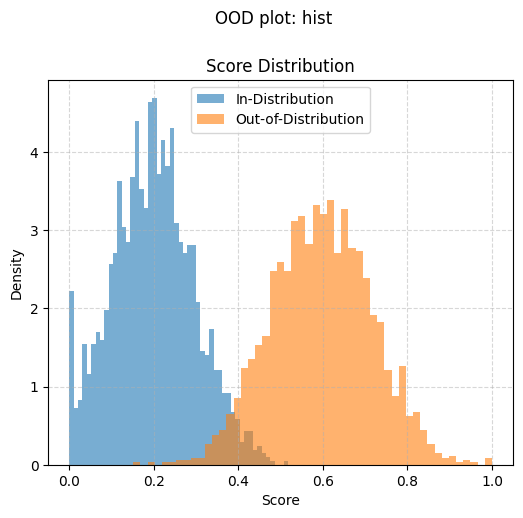

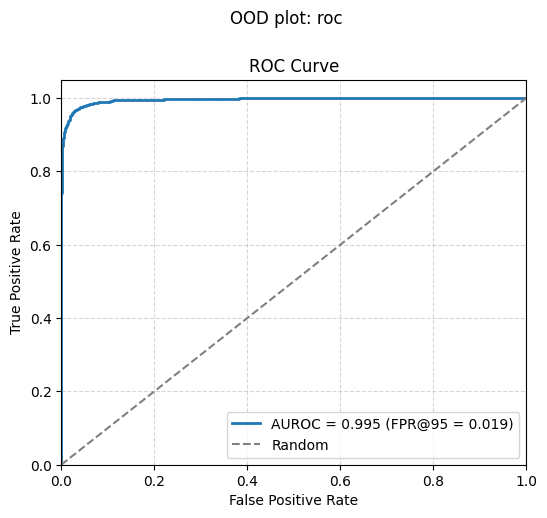

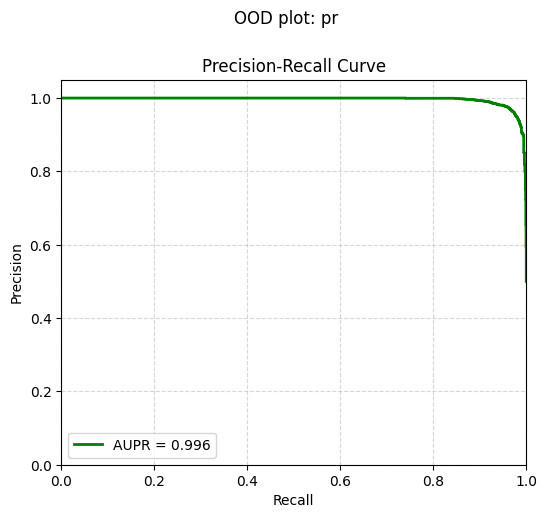

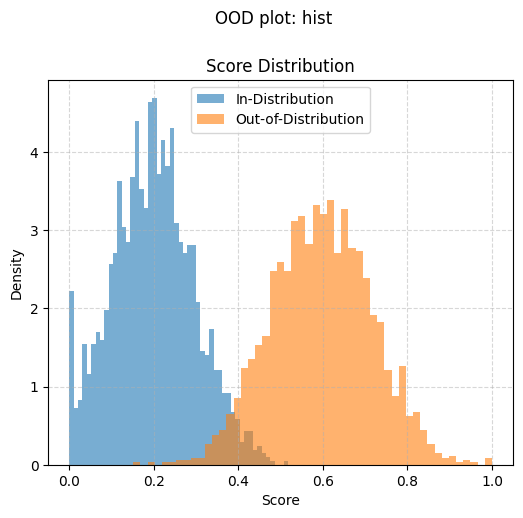

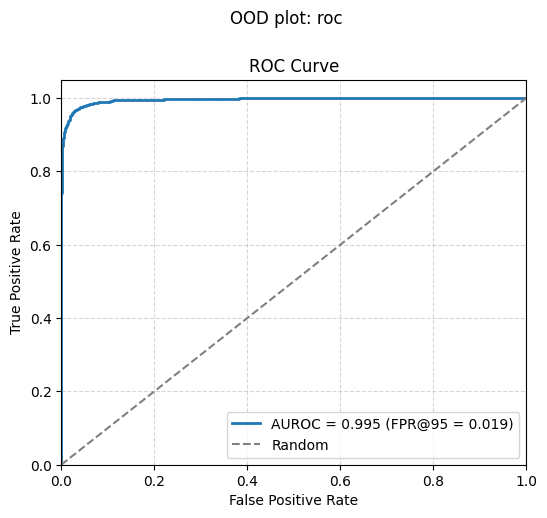

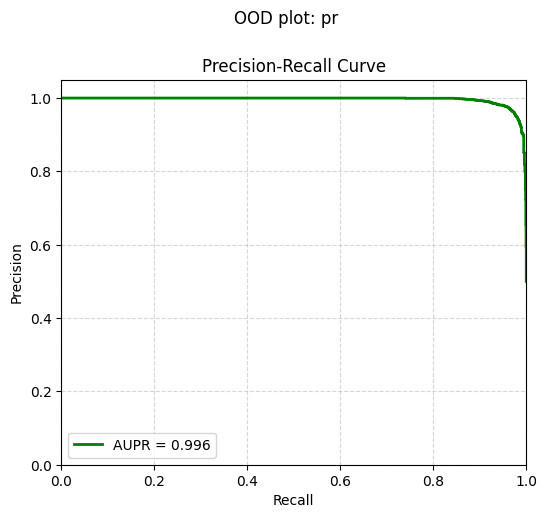

In [13]:
figs = visualize_ood(
    id_scores_anomaly,
    ood_scores_anomaly,
    plot_types=None,     # None -> generate all plots ("hist", "roc", "pr")
    invert_scores=False # IMPORTANT: anomaly scores (high = OOD)
)

for name, fig in figs.items():
    fig.suptitle(f"OOD plot: {name}", y=1.02)
    display(fig)

## Confidence Scores

We repeat the experiment using confidence scores,
where higher values indicate in-distribution samples.

In [14]:
# Toy example:
# In-distribution confidence is higher than OOD confidence
# (Confidence-score convention)

id_conf = np.random.normal(loc=0.85, scale=0.08, size=n_id)
ood_conf = np.random.normal(loc=0.35, scale=0.12, size=n_ood)

id_conf = np.clip(id_conf, 0.0, 1.0)
ood_conf = np.clip(ood_conf, 0.0, 1.0)

id_conf[:5], ood_conf[:5]

(array([0.89906793, 0.997496  , 0.87168728, 0.94091581, 0.71093345]),
 array([0.59510435, 0.23966466, 0.3637604 , 0.33350916, 0.51386323]))

## Metrics and Visualization for Confidence Scores

We demonstrate how to correctly handle confidence scores by inverting them
to match the OOD metric convention (higher score = more likely OOD).

Metrics after inversion (1 - confidence)
       auroc: 0.999725
        aupr: 0.999737
         fpr: 0.000000
         fnr: 0.018000


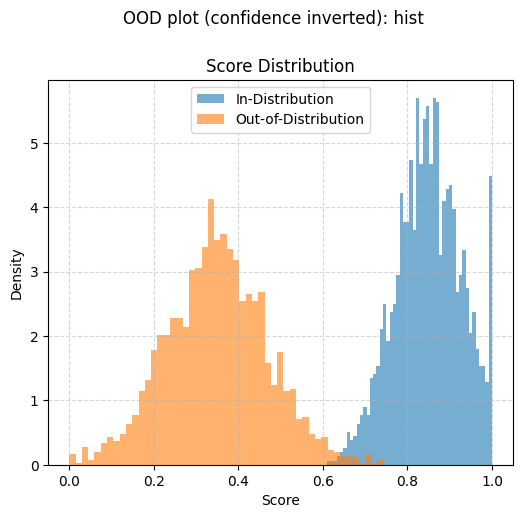

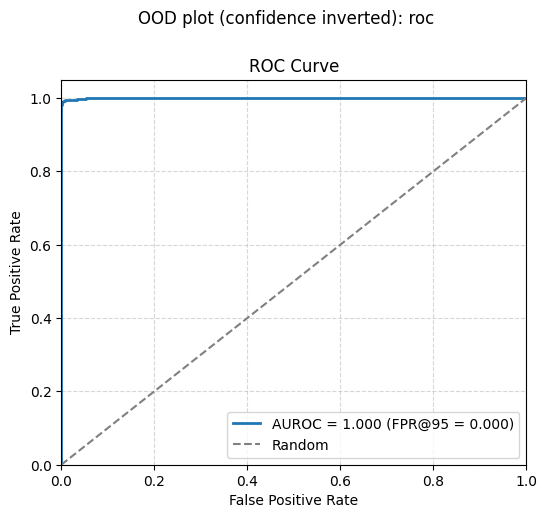

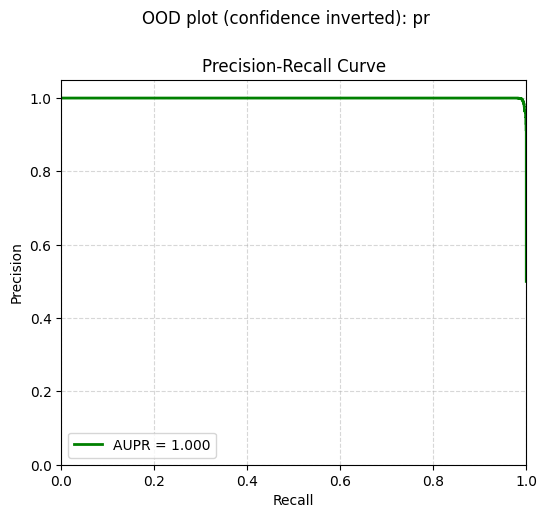

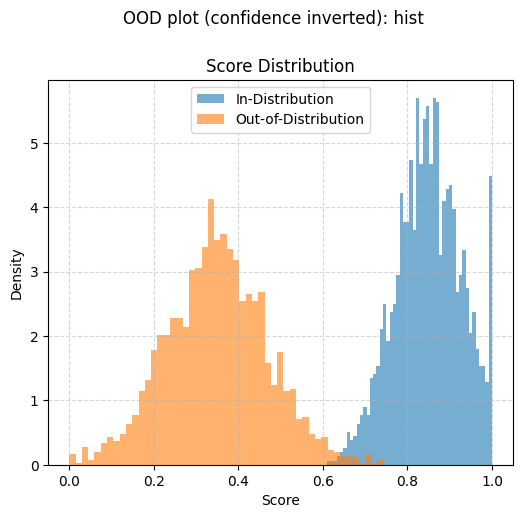

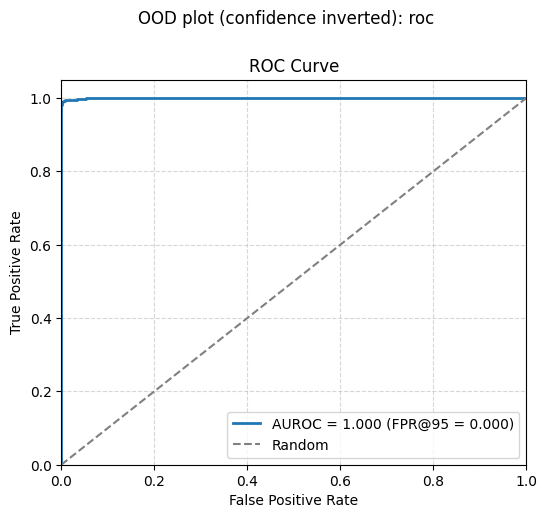

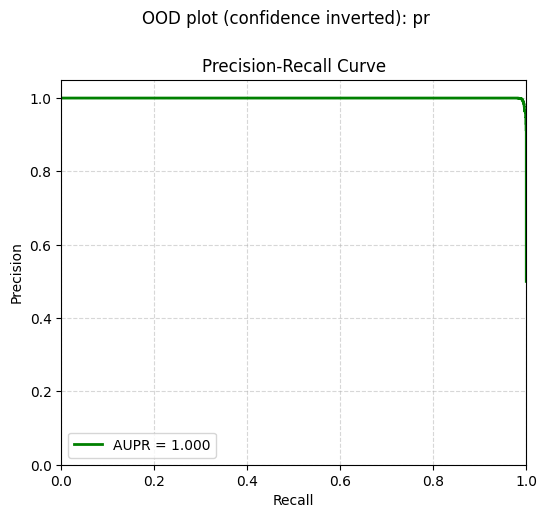

In [15]:
# IMPORTANT:
# evaluate_ood assumes "high score = OOD".
# For confidence scores (high = ID), you must invert them.

# Option A (recommended): invert before calling evaluate_ood
id_anomaly_from_conf = 1.0 - id_conf
ood_anomaly_from_conf = 1.0 - ood_conf

res_conf_fixed = evaluate_ood(
    id_anomaly_from_conf,
    ood_anomaly_from_conf,
    metrics="all",
)
pprint_dict(res_conf_fixed, "Metrics after inversion (1 - confidence)")

# Option B: for visualization only, rely on invert_scores=True (default)
figs_conf = visualize_ood(
    id_conf,
    ood_conf,
    invert_scores=True,
)

for name, fig in figs_conf.items():
    fig.suptitle(f"OOD plot (confidence inverted): {name}", y=1.02)
    display(fig)

## Metric Specification Examples

We showcase different ways to specify evaluation metrics,
including shorthand names and dynamic thresholds using percentages.

In [16]:
tests = ["auroc", "aupr", "fpr", "fnr", "fpr@0.8", "fnr@90%", "fpr@95%"]

for t in tests:
    out = evaluate_ood(id_scores_anomaly, ood_scores_anomaly, metrics=t)
    pprint_dict(out, title=f"\nmetrics='{t}'")


metrics='auroc'
       auroc: 0.995339

metrics='aupr'
        aupr: 0.995804

metrics='fpr'
         fpr: 0.019000

metrics='fnr'
         fnr: 0.049000

metrics='fpr@0.8'
     fpr@0.8: 0.000500

metrics='fnr@90%'
     fnr@90%: 0.099500

metrics='fpr@95%'
     fpr@95%: 0.019000
